<a href="https://colab.research.google.com/github/bhanuteja2001/SegPC-2021/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install livelossplot

In [3]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 3.9MB 49.0MB/s 
     |████████████████████████████████| 450kB 58.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=22b95307797d94c0d5b74c7bdc5eded67eb1409999c2b050055113f63a5eef02
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [5]:
%matplotlib inline

In [3]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [8]:
len(os.listdir('/content/drive/MyDrive/SegPC-2021/x'))

298

(192, 256, 3)


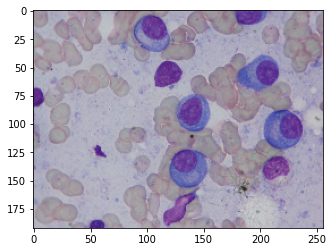

In [9]:
img_path = "/content/drive/MyDrive/SegPC-2021/x/106.bmp"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 192))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)

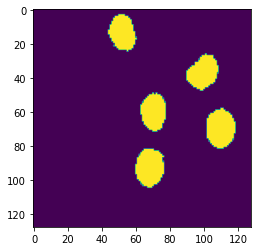

In [7]:
mask_path = "/content/drive/MyDrive/SegPC-2021/y/106.bmp"
mask = cv2.imread(mask_path, 0)
mask = cv2.resize(mask, (128, 128))
#mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
plt.imshow(mask)

In [71]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

train_images = []

for imgs in tqdm(os.listdir("/content/drive/MyDrive/SegPC-2021/x")):
  img_path = "/content/drive/MyDrive/SegPC-2021/x/" + imgs
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)
train_images = np.array(train_images)

train_masks = []

for imgs in tqdm(os.listdir("/content/drive/MyDrive/SegPC-2021/y")):
  mask_path = "/content/drive/MyDrive/SegPC-2021/y/" + imgs
  mask = cv2.imread(mask_path, 0)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  train_masks.append(mask)

train_masks = np.array(train_masks)

100%|██████████| 298/298 [01:22<00:00,  3.63it/s]


In [54]:
train_images.shape

(298, 240, 320, 3)

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [72]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [73]:
# define model
from keras import optimizers
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
adam = optimizers.Adam(lr = 0.0001)
model.compile('adam', loss=sm.losses.DiceLoss(), metrics=[sm.metrics.iou_score])


#print(model.summary())

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/SegPC-2021/checkpoints/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                                  monitor = 'iou_score',
                                  frequency='epoch',
                                  save_best_only=True,
                                  save_weight_only=False,
                                  verbose=1,
                                  mode ='auto')
    checkpoint2 = EarlyStopping(monitor='iou_score', patience=5, verbose=1, restore_best_weights=True)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [65]:
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #channel_shift_range=150.0,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=[0.4,1.5])
        
val_datagen = ImageDataGenerator(#rescale=1./255,
                                 vertical_flip=True,
                                 horizontal_flip=True,
                                 brightness_range=[0.4,1.5])

BS = 32
EPOCHS = 100

H = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size = BS),
    epochs=EPOCHS,
    #verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[PlotLossesKeras()]
    )

accuracy = model.evaluate(x_val, y_val)

Epoch 1/100


InvalidArgumentError: ignored

In [69]:
print(x_val.shape)
print(y_val.shape)

(60, 240, 320, 3)
(60, 240, 320, 1)


In [74]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=1000,
   verbose=1,
   validation_data=(x_val, y_val),
)

Train on 238 samples, validate on 60 samples
Epoch 1/1000
238/238 [==============================] - 18s 74ms/step - loss: 0.1264 - iou_score: 0.8177 - val_loss: -0.7372 - val_iou_score: 6.8869
Epoch 2/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.2577 - iou_score: 1.7584 - val_loss: -0.3280 - val_iou_score: 1.9894
Epoch 3/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.5004 - iou_score: 3.0493 - val_loss: 0.2467 - val_iou_score: 0.6068
Epoch 4/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.6322 - iou_score: 4.4481 - val_loss: -0.7258 - val_iou_score: 6.2867
Epoch 5/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.7216 - iou_score: 6.2704 - val_loss: -0.9153 - val_iou_score: 22.6457
Epoch 6/1000
238/238 [==============================] - 2s 8ms/step - loss: -0.7782 - iou_score: 8.1435 - val_loss: -0.9017 - val_iou_score: 19.3467
Epoch 7/1000
238/238 [==============================] - 2s 8ms/st

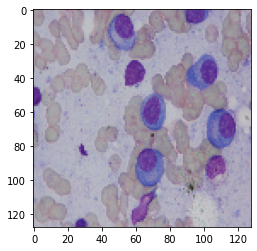

In [75]:
test_img = cv2.imread("/content/drive/MyDrive/SegPC-2021/x/106.bmp", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

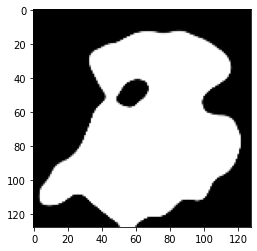

In [76]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')